In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator   # for the fingerprint generation
import numpy as np  # for the dimensionality reduction process of the fingerprint datas
import os
import pandas as pd
from PIL import Image
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

In [3]:
work_dir = r"E:\Users\clasper\Documents\杂七杂八\2509\AI4S\2506靶点小分子活性预测"
os.chdir(work_dir)

In [4]:
smi_file = "molecule.smi"
mol_ids = []
mols = []
invalid_mols = []

with open(smi_file, "r") as f:
    for line in f.readlines():
        line = line.strip()
        parts = line.split(",")
        if parts[0] == "molecule_id":
            continue
        mol_id = parts[0].strip()
        smiles = parts[1].strip()
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            invalid_mols.append((mol_id, smiles))
            continue
        mol_ids.append(mol_id)
        mols.append(mol)

print(len(mols))

200


In [ ]:
grid_img = Draw.MolsToGridImage(
    mols = mols, 
    molsPerRow = 20, 
    subImgSize = (500, 500), 
    legends = mol_ids, 
    maxMols=len(mols), 
    useSVG = True
)
# print(type(grid_img))

svg_data = grid_img.data
if isinstance(svg_data, bytes):
    svg_str = svg_data.decode('utf-8')
else:
    svg_str = svg_data

# with open("molecules.svg", "w", encoding = "utf-8") as f:
#     f.write(svg_str)

In [5]:
fps = []
gen = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 1024)
for mol in mols:
    fingerprint = gen.GetFingerprint(mol)
    if fingerprint:
        fps.append(fingerprint)

X = np.array(fps)
print(X.shape)

(200, 1024)


### 聚类

In [6]:
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

In [24]:
def ClusterFps(fps, cutoff = 0.8):
    dists = []
    nfps = len(fps)
    
    # generate the distance matrix
    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - x for x in sims])
    
    # cluster the data
    cs = Butina.ClusterData(dists, nfps, cutoff, isDistData = True)
    return cs

In [28]:
clusters = ClusterFps(fps)
len(clusters)

76

### 降维

In [26]:
import pandas as pd
from sklearn.manifold import TSNE

In [27]:
df = pd.DataFrame(clusters, columns = ['Cluster'])
df

ValueError: 1 columns passed, passed data had 36 columns

In [11]:
tsne_model = TSNE(n_components = 2, random_state = 42, perplexity = 20, max_iter = 5000)
tsne_result = tsne_model.fit_transform(X)

In [12]:
# tsne_result
df['tSNE_1'] = tsne_result[:, 0]
df['tSNE_2'] = tsne_result[:, 1]

df

,Cluster,tSNE_1,tSNE_2
0,199,-2.557244,-3.033595
1,198,2.484569,-2.944602
2,197,0.736301,0.762107
3,196,-2.026211,0.373317
4,195,-1.078293,0.793182
...,...,...,...
195,4,-3.812383,0.789728
196,3,1.322781,2.771949
197,2,-3.973728,3.724444
198,1,-0.936178,-0.882249


### 可视化

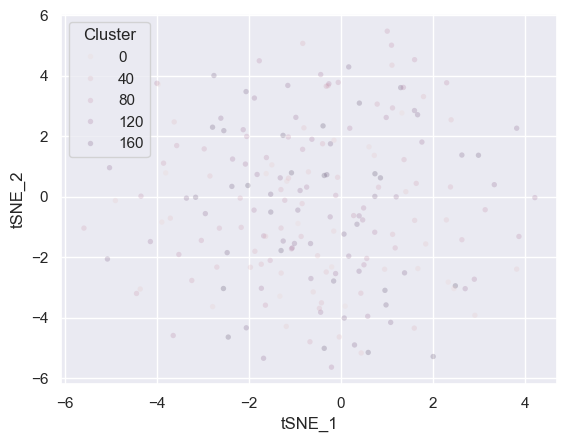

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.scatterplot(x='tSNE_1', y='tSNE_2', hue='Cluster', s = 15,  data=df, alpha=0.2, edgecolors='none')
plt.show()

In [28]:
import inspect
from sklearn.manifold import TSNE
print(inspect.signature(TSNE.__init__))

(self, n_components=2, *, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto', max_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None)
